Loading data...
X shape: (21799, 1000, 12)
Y shape: (21799, 29)

Removing baseline wander...


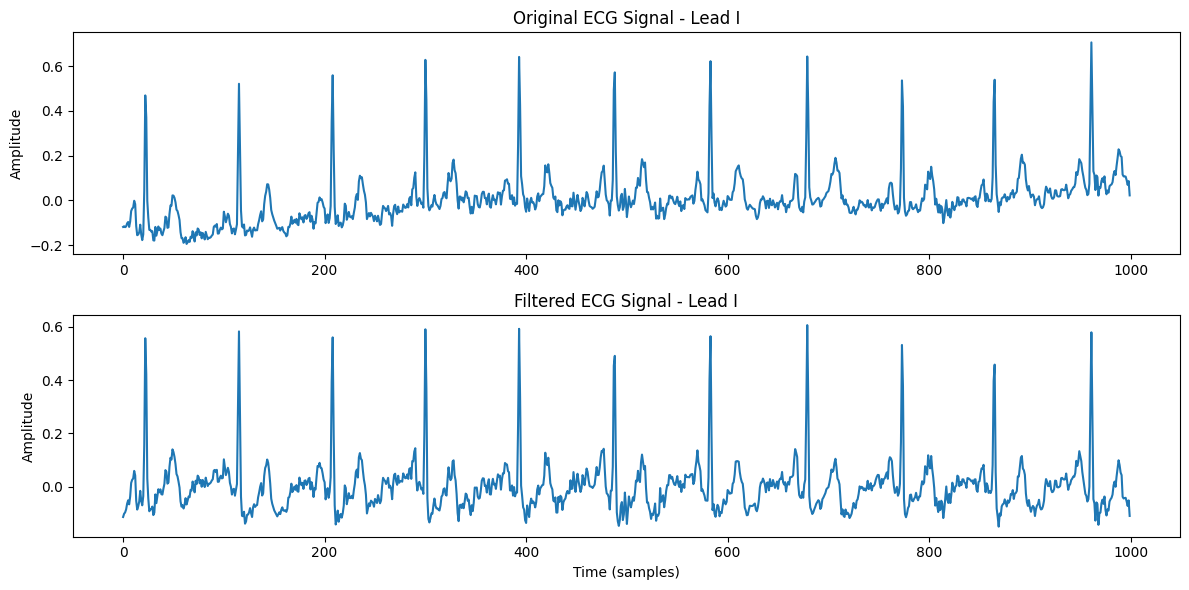


Standardizing signals...
Scaled data shape: (21799, 1000, 12)
Mean: -0.000000, Std: 1.000000

Class Distribution:
has_IHD
0    16330
1     5469
Name: count, dtype: int64

Class imbalance ratio: 2.99:1

Data Split:
Training set: 15259 samples
  - IHD positive: 3828 (25.09%)
  - Normal: 11431 (74.91%)

Validation set: 3270 samples
  - IHD positive: 820 (25.08%)
  - Normal: 2450 (74.92%)

Test set: 3270 samples
  - IHD positive: 821 (25.11%)
  - Normal: 2449 (74.89%)


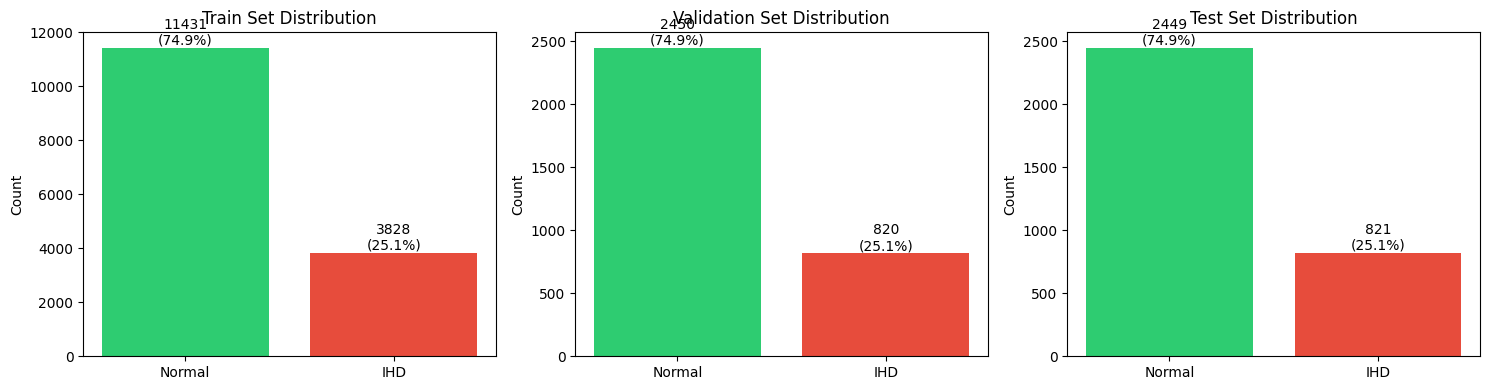


Saving processed data...
Processed data saved successfully!

Files created:
- X_train.npy, y_train.npy
- X_val.npy, y_val.npy
- X_test.npy, y_test.npy
- scaler.pkl
- filtering_comparison.png
- data_split_distribution.png


In [1]:
# PTB-XL ECG Dataset - Data Preprocessing
# Notebook 2: Data Cleaning, Normalization, and Train-Test Split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

# ==========================================
# 1. LOAD DATA
# ==========================================

print("Loading data...")
X = np.load('../data/X_raw.npy')
Y = pd.read_csv('../data/Y_labels.csv', index_col=0)

print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")

# ==========================================
# 2. REMOVE BASELINE WANDER
# ==========================================

def remove_baseline_wander(ecg_signal, sampling_rate=100):
    """Remove baseline wander using high-pass filter"""
    # High-pass Butterworth filter at 0.5 Hz
    sos = signal.butter(4, 0.5, btype='high', fs=sampling_rate, output='sos')
    filtered = signal.sosfilt(sos, ecg_signal, axis=0)
    return filtered

print("\nRemoving baseline wander...")
X_filtered = np.array([remove_baseline_wander(x) for x in X])

# Visualize filtering effect
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

sample_idx = 0
axes[0].plot(X[sample_idx, :, 0])
axes[0].set_title('Original ECG Signal - Lead I')
axes[0].set_ylabel('Amplitude')

axes[1].plot(X_filtered[sample_idx, :, 0])
axes[1].set_title('Filtered ECG Signal - Lead I')
axes[1].set_xlabel('Time (samples)')
axes[1].set_ylabel('Amplitude')

plt.tight_layout()
plt.savefig('../results/figures/filtering_comparison.png', dpi=300)
plt.show()

# ==========================================
# 3. STANDARDIZATION
# ==========================================

print("\nStandardizing signals...")

# Reshape for standardization
n_samples, n_timesteps, n_leads = X_filtered.shape
X_reshaped = X_filtered.reshape(-1, n_leads)

# Standardize each lead independently
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)

# Reshape back
X_scaled = X_scaled.reshape(n_samples, n_timesteps, n_leads)

print(f"Scaled data shape: {X_scaled.shape}")
print(f"Mean: {X_scaled.mean():.6f}, Std: {X_scaled.std():.6f}")

# ==========================================
# 4. HANDLE CLASS IMBALANCE
# ==========================================

print(f"\n{'='*50}")
print("Class Distribution:")
print(f"{'='*50}")
class_counts = Y['has_IHD'].value_counts()
print(class_counts)
print(f"\nClass imbalance ratio: {class_counts[0]/class_counts[1]:.2f}:1")

# ==========================================
# 5. TRAIN-VALIDATION-TEST SPLIT
# ==========================================

# Use stratified split to maintain class distribution
y_labels = Y['has_IHD'].values

# First split: 70% train, 30% temp (for val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y_labels, 
    test_size=0.3, 
    random_state=42, 
    stratify=y_labels
)

# Second split: 15% validation, 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.5, 
    random_state=42, 
    stratify=y_temp
)

print(f"\n{'='*50}")
print("Data Split:")
print(f"{'='*50}")
print(f"Training set: {X_train.shape[0]} samples")
print(f"  - IHD positive: {y_train.sum()} ({y_train.mean()*100:.2f}%)")
print(f"  - Normal: {(y_train==0).sum()} ({(1-y_train.mean())*100:.2f}%)")

print(f"\nValidation set: {X_val.shape[0]} samples")
print(f"  - IHD positive: {y_val.sum()} ({y_val.mean()*100:.2f}%)")
print(f"  - Normal: {(y_val==0).sum()} ({(1-y_val.mean())*100:.2f}%)")

print(f"\nTest set: {X_test.shape[0]} samples")
print(f"  - IHD positive: {y_test.sum()} ({y_test.mean()*100:.2f}%)")
print(f"  - Normal: {(y_test==0).sum()} ({(1-y_test.mean())*100:.2f}%)")

# ==========================================
# 6. VISUALIZE SAMPLE DISTRIBUTION
# ==========================================

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

splits = ['Train', 'Validation', 'Test']
y_data = [y_train, y_val, y_test]

for idx, (split, y) in enumerate(zip(splits, y_data)):
    counts = pd.Series(y).value_counts()
    axes[idx].bar(['Normal', 'IHD'], [counts[0], counts[1]], 
                  color=['#2ecc71', '#e74c3c'])
    axes[idx].set_title(f'{split} Set Distribution')
    axes[idx].set_ylabel('Count')
    
    # Add percentage labels
    total = len(y)
    for i, v in enumerate([counts[0], counts[1]]):
        axes[idx].text(i, v, f'{v}\n({v/total*100:.1f}%)', 
                      ha='center', va='bottom')

plt.tight_layout()
plt.savefig('../results/figures/data_split_distribution.png', dpi=300)
plt.show()

# ==========================================
# 7. SAVE PROCESSED DATA
# ==========================================

print(f"\n{'='*50}")
print("Saving processed data...")

np.save('../data/X_train.npy', X_train)
np.save('../data/X_val.npy', X_val)
np.save('../data/X_test.npy', X_test)
np.save('../data/y_train.npy', y_train)
np.save('../data/y_val.npy', y_val)
np.save('../data/y_test.npy', y_test)

# Save scaler for future use
import pickle
with open('../data/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Processed data saved successfully!")
print(f"{'='*50}")
print("\nFiles created:")
print("- X_train.npy, y_train.npy")
print("- X_val.npy, y_val.npy")
print("- X_test.npy, y_test.npy")
print("- scaler.pkl")
print("- filtering_comparison.png")
print("- data_split_distribution.png")